In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt

from IMNN.experimental.jax.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from IMNN.experimental.jax.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from IMNN.experimental.jax.utils import value_and_jacrev

rng = jax.random.PRNGKey(0)


jax version:  0.2.7


In [38]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)


In [19]:
!XLA_FLAGS=--xla_cpu_enable_fast_math=false

In [20]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [21]:
# bring in 2D simulator
from make_sims import LogNormalPowerBox,PowerBox

# Model in STAX

In [22]:
n_summaries = 2
n_s = 500
n_d = 500
λ = 10.0
ϵ = 0.1

In [23]:
model = stax.serial(stax.Conv(32, (3,3), strides=(2,2), padding="SAME"),
                                 stax.LeakyRelu,
                                 stax.Conv(64, (3,3), strides=(2,2), padding="SAME"),
                                 stax.LeakyRelu,
                                 stax.Conv(128, (3,3), strides=(2,2), padding="SAME"),
                                 stax.LeakyRelu,
                                 stax.Conv(256, (3,3), strides=(2,2), padding="SAME"),
                                 stax.LeakyRelu,
                                 stax.Conv(512, (3,3), strides=(2,2), padding="SAME"), 
                                 stax.LeakyRelu,
                                 stax.Conv(1024, (3,3), strides=(2,2), padding="SAME"),
                                 stax.LeakyRelu,
                                 stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
                                 stax.Flatten, 
                                 #stax.LeakyRelu,
                                 #stax.Dense(n_summaries),
                                 #stax.Flatten, 
)

In [24]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [25]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [26]:
rng, abc_key = jax.random.split(rng)

# Simulator in JAX

In [27]:
θ_fid = np.array([2., 0.8])
δθ = np.array([0.1, 0.1])
n_params = 2
input_shape = (1,1, 128,128)
simulator_args = {"input shape": input_shape, "squeeze": False}

In [39]:
def simulator(rng, θ, simulator_args=simulator_args):
    #seed,subkeys = jax.random.split(rng)
    A,B = θ
    @jit
    def pk(k, A=A, B=B):
       # return A*np.array(k, dtype='float64')**-B
        return A*np.sign(k)*(np.abs(k)**-B)
    
    pb = PowerBox(
        N=simulator_args['input shape'][2],            # Number of grid-points in the box
        seed = rng,                # Set a seed to ensure the box looks the same every time
        dim=2,                     # 2D box
        pk = pk,  # The power-spectrum
        boxlength = 1.0,           # Size of the box (sets the units of k in pk)
        vol_normalised_power=False
    )
    if simulator_args["squeeze"]:
        return pb.delta_x()
    
    else:
        return np.expand_dims((np.expand_dims(pb.delta_x(), axis=0)), axis=0).astype('complex128')

In [40]:
# test simulator
seed,subkey = jax.random.split(rng)

plt.imshow((simulator(seed, θ_fid, simulator_args={"input shape": input_shape, "squeeze": True})),extent=(0,1,0,1))
plt.colorbar()
plt.show()

k:  [[568.68901608 564.26362454 559.87376772 ... 555.52028803 559.87376772
  564.26362454]
 [564.26362454 559.80325021 555.37813852 ... 550.98913907 555.37813852
  559.80325021]
 [559.87376772 555.37813852 550.91748433 ... 546.49266159 550.91748433
  555.37813852]
 ...
 [555.52028803 550.98913907 546.49266159 ... 542.03171846 546.49266159
  550.98913907]
 [559.87376772 555.37813852 550.91748433 ... 546.49266159 550.91748433
  555.37813852]
 [564.26362454 559.80325021 555.37813852 ... 550.98913907 555.37813852
  559.80325021]]
Invalid value encountered in the output of a jit function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in mul

In [30]:
k = np.linspace(-10, 10, 20, dtype='complex')
print(k)
pk = lambda k: 1.0*np.sign(k)*(np.abs(k)**-2.9)
k = np.where(k != 0., pk(k), k)
k
#k = np.array(k)

[-10.        +0.j  -8.94736842+0.j  -7.89473684+0.j  -6.84210526+0.j
  -5.78947368+0.j  -4.73684211+0.j  -3.68421053+0.j  -2.63157895+0.j
  -1.57894737+0.j  -0.52631579+0.j   0.52631579+0.j   1.57894737+0.j
   2.63157895+0.j   3.68421053+0.j   4.73684211+0.j   5.78947368+0.j
   6.84210526+0.j   7.89473684+0.j   8.94736842+0.j  10.        +0.j]


DeviceArray([-1.25892541e-03+0.j, -1.73813526e-03+0.j,
             -2.49873840e-03+0.j, -3.78398774e-03+0.j,
             -6.14252108e-03+0.j, -1.09921378e-02+0.j,
             -2.27824868e-02+0.j, -6.04466769e-02+0.j,
             -2.65909470e-01+0.j, -6.43258365e+00+0.j,
              6.43258365e+00+0.j,  2.65909470e-01+0.j,
              6.04466769e-02+0.j,  2.27824868e-02+0.j,
              1.09921378e-02+0.j,  6.14252108e-03+0.j,
              3.78398774e-03+0.j,  2.49873840e-03+0.j,
              1.73813526e-03+0.j,  1.25892541e-03+0.j], dtype=complex128)

In [31]:
k = np.linspace(0, 10, 10).astype('complex64')
def four(k):
    return np.fft.ifft(k)

value_and_jacrev(four, argnums=0, holomorphic=True)(k);

In [36]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [37]:
np.squeeze(simulator_gradient(rng, θ_fid.astype("complex128"))[1]).T[1]

k:  [[568.68901608 564.26362454 559.87376772 ... 555.52028803 559.87376772
  564.26362454]
 [564.26362454 559.80325021 555.37813852 ... 550.98913907 555.37813852
  559.80325021]
 [559.87376772 555.37813852 550.91748433 ... 546.49266159 550.91748433
  555.37813852]
 ...
 [555.52028803 550.98913907 546.49266159 ... 542.03171846 546.49266159
  550.98913907]
 [559.87376772 555.37813852 550.91748433 ... 546.49266159 550.91748433
  555.37813852]
 [564.26362454 559.80325021 555.37813852 ... 550.98913907 555.37813852
  559.80325021]]
k shape:  (128, 128)


DeviceArray([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj,
              nan+nanj],
             [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj,
              nan+nanj],
             [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj,
              nan+nanj],
             ...,
             [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj,
              nan+nanj],
             [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj,
              nan+nanj],
             [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj,
              nan+nanj]], dtype=complex128)

In [19]:
plt.imshow(np.squeeze(simulator_gradient(rng, θ_fid)[1].T[0]))
plt.colorbar()

k:  [[568.68901608 564.26362454 559.87376772 ... 555.52028803 559.87376772
  564.26362454]
 [564.26362454 559.80325021 555.37813852 ... 550.98913907 555.37813852
  559.80325021]
 [559.87376772 555.37813852 550.91748433 ... 546.49266159 550.91748433
  555.37813852]
 ...
 [555.52028803 550.98913907 546.49266159 ... 542.03171846 546.49266159
  550.98913907]
 [559.87376772 555.37813852 550.91748433 ... 546.49266159 550.91748433
  555.37813852]
 [564.26362454 559.80325021 555.37813852 ... 550.98913907 555.37813852
  559.80325021]]
Invalid value encountered in the output of a jit function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in mul

In [16]:
def get_simulations(rng, n_s, θ, simulator_args=simulator_args):
    def get_simulator(key):
        return simulator(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_simulator)(np.array(keys))


def get_simulation_gradients(rng, n_s, n_d, θ, simulator_args=simulator_args):
    def get_batch_gradient(key):
        return simulator_gradient(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_batch_gradient)(np.array(keys)[:n_d])

In [108]:
rng, *training_keys = jax.random.split(rng, num=1 + n_s)

In [109]:
fiducial, derivative = jax.vmap(
    partial(simulator_gradient, θ=θ_fid, simulator_args=simulator_args))(np.array(training_keys))

KeyboardInterrupt: 

In [ ]:
numerical_derivative = np.stack(
    [
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] - δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] - δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
            ],
            1,
        ),
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] + δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] + δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
            ],
            1,
        ),
    ],
    1,
)

In [ ]:
rng, *validation_keys = jax.random.split(rng, num=1 + n_s)

In [ ]:
validation_fiducial, validation_derivative = jax.vmap(
    partial(simulator_gradient, θ=θ_fid, simulator_args=simulator_args)
)(np.array(validation_keys))

In [ ]:
validation_numerical_derivative = np.stack(
    [
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] - δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] - δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
            ],
            1,
        ),
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] + δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] + δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
            ],
            1,
        ),
    ],
    1,
)

# Initialise IMNN

In [202]:
from IMNN.experimental.jax.imnn import IMNN
from IMNN.experimental.jax.utils import check_simulator

class SimIMNN(IMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key, simulator, verbose=True):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key=key,
            optimiser=optimiser,
            verbose=verbose)
        self.simulator = check_simulator(simulator)
        self.simulate = True

    def get_fitting_keys(self, rng):
        return jax.random.split(rng, num=3)

    def get_summaries(self, rng, w, θ, n_sims, n_ders, validate=False):
        def get_summary(key, θ):
            return self.model(w, self.simulator(key, θ))
        def get_derivatives(key):
            return value_and_jacrev(get_summary, argnums=1)(key, θ)
        keys = np.array(jax.random.split(rng, num=n_sims))
        summaries, derivatives = jax.vmap(get_derivatives)(keys[:n_ders])
        #print(derivatives.shape)
        if n_sims > n_ders:
            summaries = np.vstack([
                summaries,
                jax.vmap(partial(get_summary, θ=θ))(keys[n_ders:])])
        return np.squeeze(summaries), np.squeeze(derivatives)

In [209]:
IMNNs = [SimIMNN(
        n_s=1000,
        n_d=1000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        )]

In [204]:
IMNNs = [
    SimulatorIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
    ),
    AggregatedSimulatorIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        devices=jax.devices(),
        n_per_device=n_s // 2,
    ),
    SimulatorIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
    ),
    AggregatedSimulatorIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        devices=jax.devices(),
        n_per_device=100,
    ),
    GradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
    ),
    AggregatedGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
        devices=jax.devices(),
        n_per_device=n_s // 2,
    ),
    GradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative,
    ),
    AggregatedGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative,
        devices=jax.devices(),
        n_per_device=100,
    ),
    GradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative[:100],
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative[:100],
    ),
    AggregatedGradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative[:100],
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative[:100],
        devices=jax.devices(),
        n_per_device=100,
    ),
    NumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
    ),
    AggregatedNumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
        devices=jax.devices(),
        n_per_device=n_s // 2),
    NumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative,
    ),
     AggregatedNumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative,
        devices=jax.devices(),
        n_per_device=n_s // 2),
    NumericalGradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative[:100],
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative[:100],
    ),
     AggregatedNumericalGradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative[:100],
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative[:100],
        devices=jax.devices(),
        n_per_device=100)
]

NameError: name 'fiducial' is not defined

# Fit

In [210]:
IMNN_rngs = 1 * [fitting_key] #+ 12 * [None]
labels = [
    "Simulator\n",
    "Aggregated simulator\n",
    "Simulator\n$n_d=100$\n",
    "Aggregated simulator\n$n_d=100$\n",
    "Precomputed\n(no validation)\n",
    "Aggregated precomputed\n(no validation)\n",
    "Precomputed\n",
    "Aggregated precomputed\n",
    "Precomputed\n$n_d=100$\n",
    "Aggregated precomputed\n$n_d=100$\n",
    "Precomputed\n(numerical gradient)\n(no validation)\n",
    "Aggregated precomputed\n(numerical gradient)\n(no validation)\n",
    "Precomputed\n(numerical gradient)\n",
    "Aggregated precomputed\n(numerical gradient)\n",
    "Precomputed\n(numerical gradient)\n$n_d=100$\n",
    "Aggregated precomputed\n(numerical gradient)\n$n_d=100$\n"
]

In [211]:
[IMNN.fit(λ=λ, ϵ=ϵ, rng=IMNN_rng) for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs)];

/mnt/home/tmakinen/repositories/scratch/dev-imnn/imnn/examples/make_sims/dft.py:213: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


In [216]:
IMNNs[0].history

{'detF': DeviceArray([nan, nan, nan, ..., nan, nan, nan], dtype=float32),
 'detC': DeviceArray([1.7030596e-12,           nan,           nan, ...,
                        nan,           nan,           nan], dtype=float32),
 'detinvC': DeviceArray([5.871773e+11,          nan,          nan, ...,          nan,
                       nan,          nan], dtype=float32),
 'Λ2': DeviceArray([1412907.2,       nan,       nan, ...,       nan,       nan,
                    nan], dtype=float32),
 'r': DeviceArray([10., nan, nan, ..., nan, nan, nan], dtype=float32),
 'val_detF': DeviceArray([], dtype=float32),
 'val_detC': DeviceArray([], dtype=float32),
 'val_detinvC': DeviceArray([], dtype=float32),
 'val_Λ2': DeviceArray([], dtype=float32),
 'val_r': DeviceArray([], dtype=float32),
 'max_detF': DeviceArray(0., dtype=float32)}

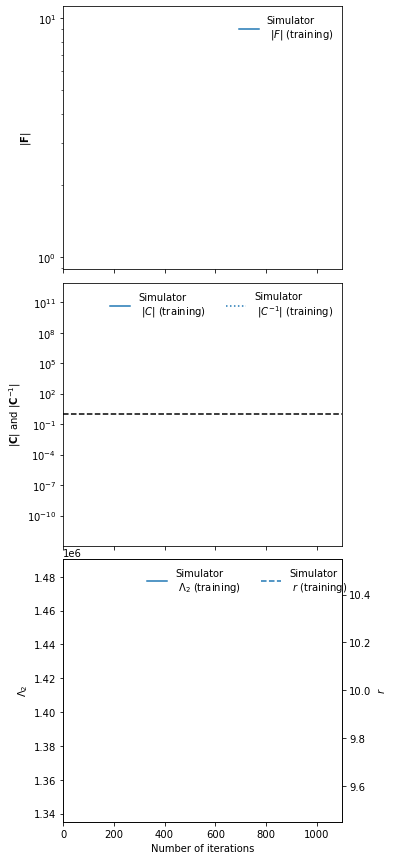

In [214]:
for i, (IMNN, label) in enumerate(zip(IMNNs, labels)):
    if i == 0:
        ax = IMNN.training_plot(expected_detF=None, colour="C{}".format(i), label=label)
    elif i == 10:
        other_ax = IMNN.training_plot(
            expected_detF=None, colour="C{}".format(i), label=label
        )
    elif i == 11:
        IMNN.training_plot(
            ax=other_ax,
            expected_detF=50, colour="C{}".format(i), label=label
        )
        other_ax[0].set_yscale("log")
        other_ax[2].set_yscale("log")
    else:
        IMNN.training_plot(
            ax=ax, expected_detF=None, colour="C{}".format(i), label=label, ncol=5
        );
ax[0].set_yscale("log")

# Data for ABC example

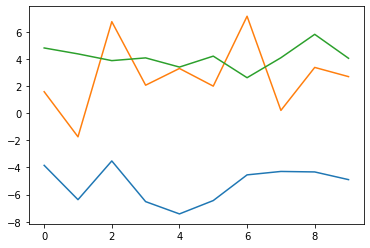

In [22]:
rng, key = jax.random.split(rng)
target_data = simulator(
    key,
    (np.array([-5.0, 2.0, 4.0]), np.array([2.0, 5.0, 1.0])),
    simulator_args=simulator_args,
)
plt.plot(target_data.T);

In [23]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]

    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = jax.random.split(key, num=len(self.event_shape))
        return [
            jax.random.uniform(
                keys[i], shape=(n,), minval=self.low[i], maxval=self.high[i]
            )
            for i in range(len(self.event_shape))
        ]


prior = uniform([-10.0, 0.0], [10.0, 10.0])

# Gaussian approximation

In [24]:
estimates = [IMNN.get_estimate(target_data) for IMNN in IMNNs]

In [25]:
GAs = [
    GaussianApproximation(estimate, IMNN.invF, prior)
    for IMNN, estimate in zip(IMNNs, estimates)
]

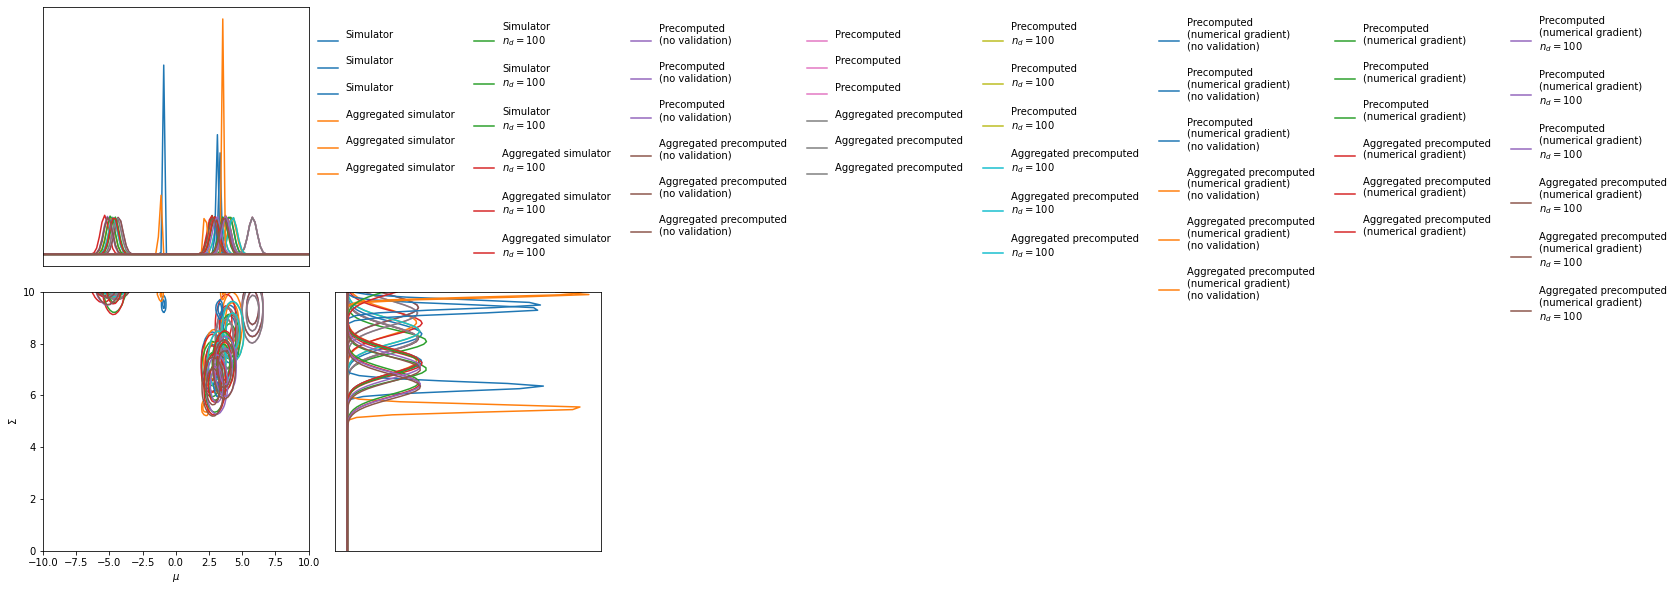

In [26]:
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$\mu$", r"$\Sigma$"], label=label, colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

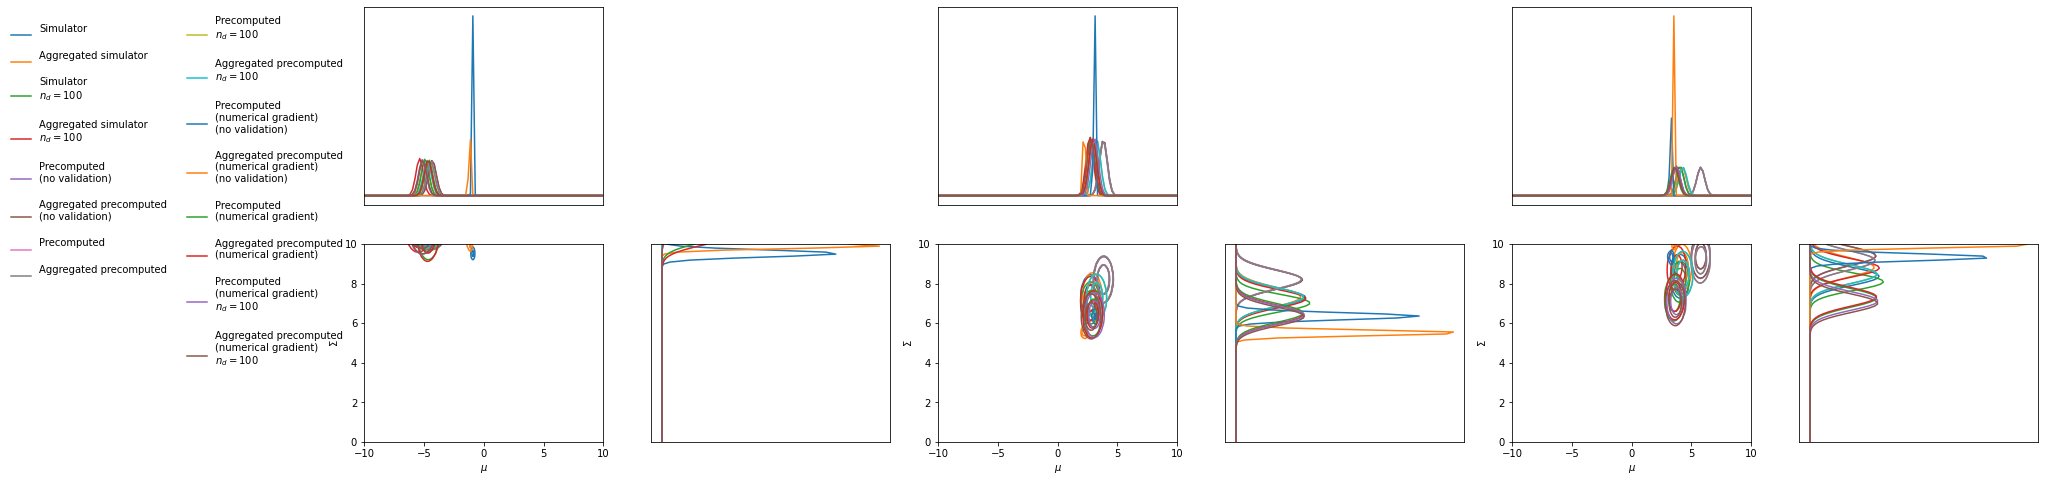

In [27]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax1 = GA.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = GA.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = GA.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        GA.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        GA.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        GA.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

# ABC

In [28]:
ABCs = [
    ApproximateBayesianComputation(
        target_data, prior, simulator, IMNN.get_estimate, F=IMNN.F, gridsize=50
    )
    for IMNN, estimate in zip(IMNNs, estimates)
]

In [29]:
[
    ABC(
        rng=abc_key,
        n_samples=int(1e6),
        min_accepted=100,
        max_iterations=100,
        ϵ=0.1,
        smoothing=1,
    )
    for ABC in ABCs
];

149 accepted in last 3 iterations  (3000000 simulations done). 
135 accepted in last 2 iterations  (2000000 simulations done). 
113 accepted in last 2 iterations  (2000000 simulations done). 
143 accepted in last 2 iterations  (2000000 simulations done). 
120 accepted in last 4 iterations  (4000000 simulations done). 
121 accepted in last 4 iterations  (4000000 simulations done). 
122 accepted in last 4 iterations  (4000000 simulations done). 
124 accepted in last 4 iterations  (4000000 simulations done). 
175 accepted in last 2 iterations  (2000000 simulations done). 
176 accepted in last 2 iterations  (2000000 simulations done). 
100 accepted in last 81 iterations  (81000000 simulations done). 


RuntimeError: Resource exhausted: Out of memory while trying to allocate 1200000000 bytes.

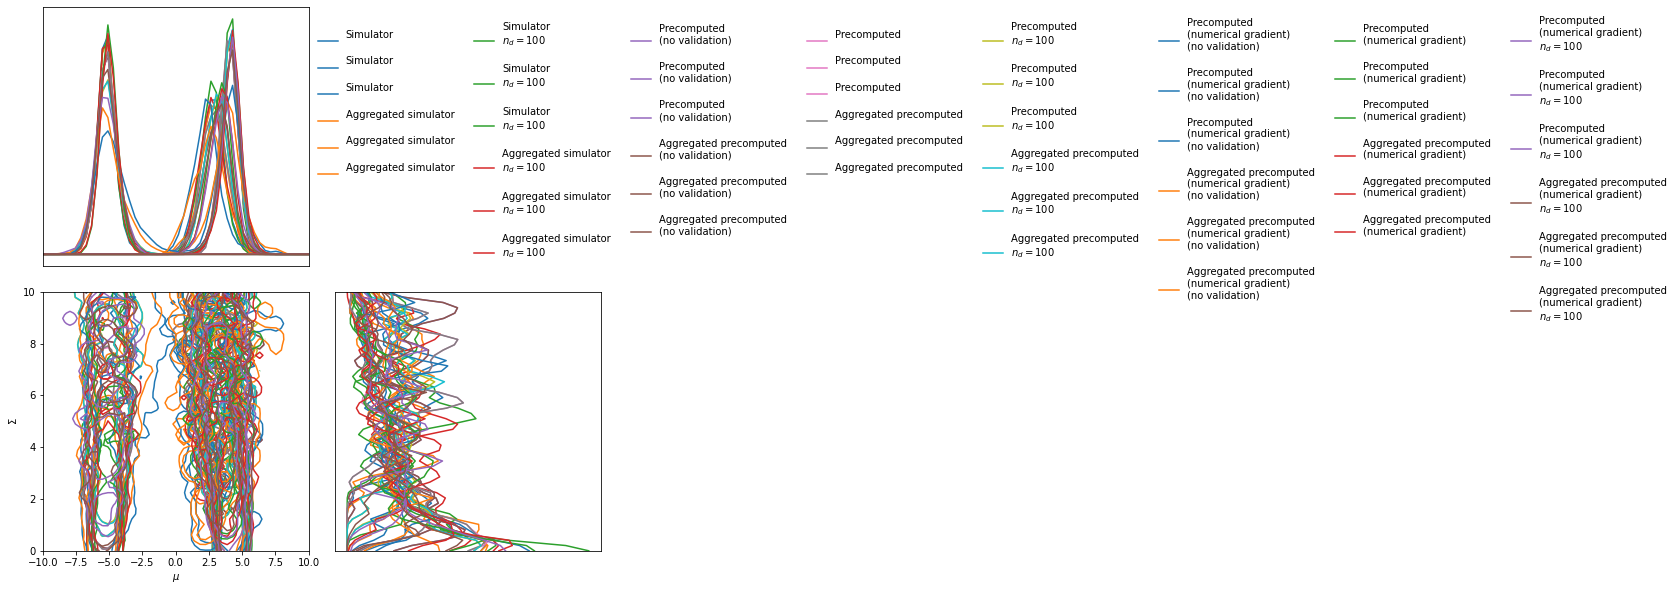

In [45]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax = ABC.marginal_plot(
            axis_labels=[r"$\mu$", r"$\Sigma$"], label=label, colours="C{}".format(i)
        )
    else:
        ABC.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

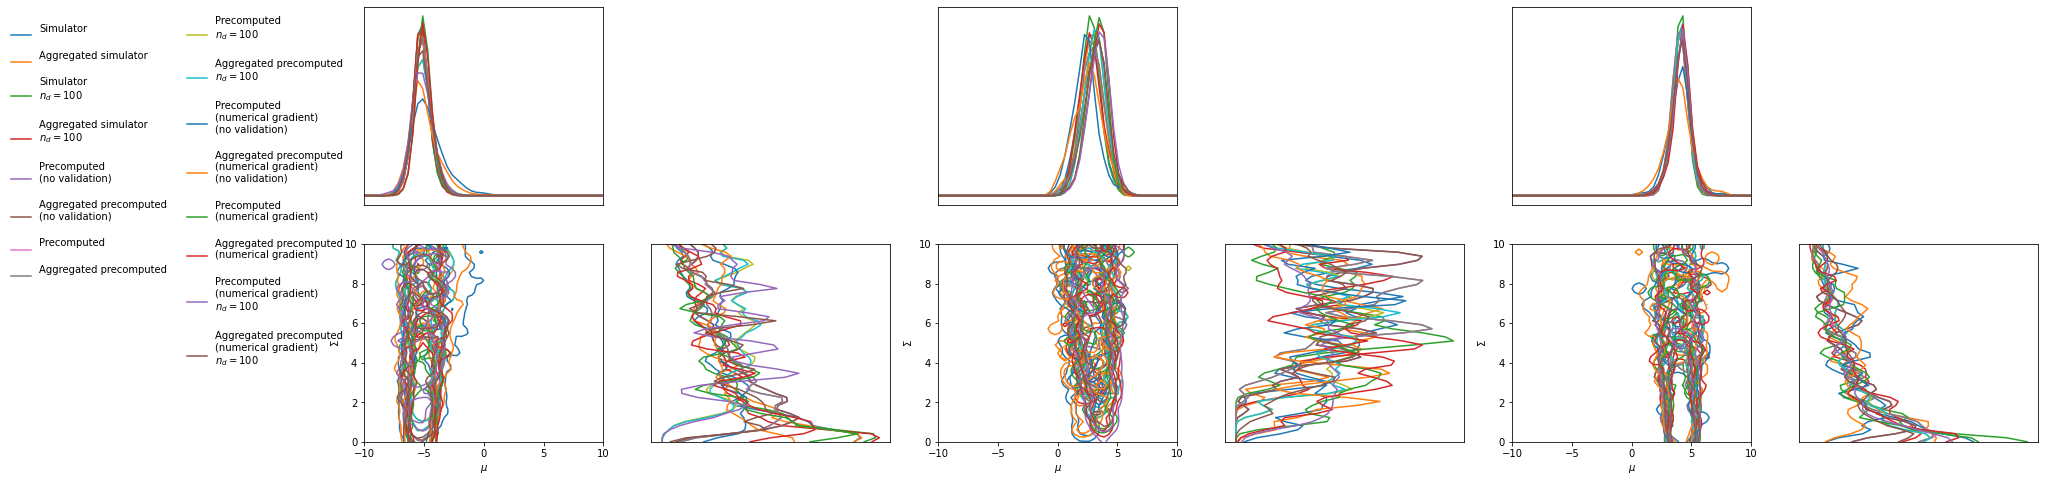

In [46]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax1 = ABC.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = ABC.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = ABC.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        ABC.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        ABC.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        ABC.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

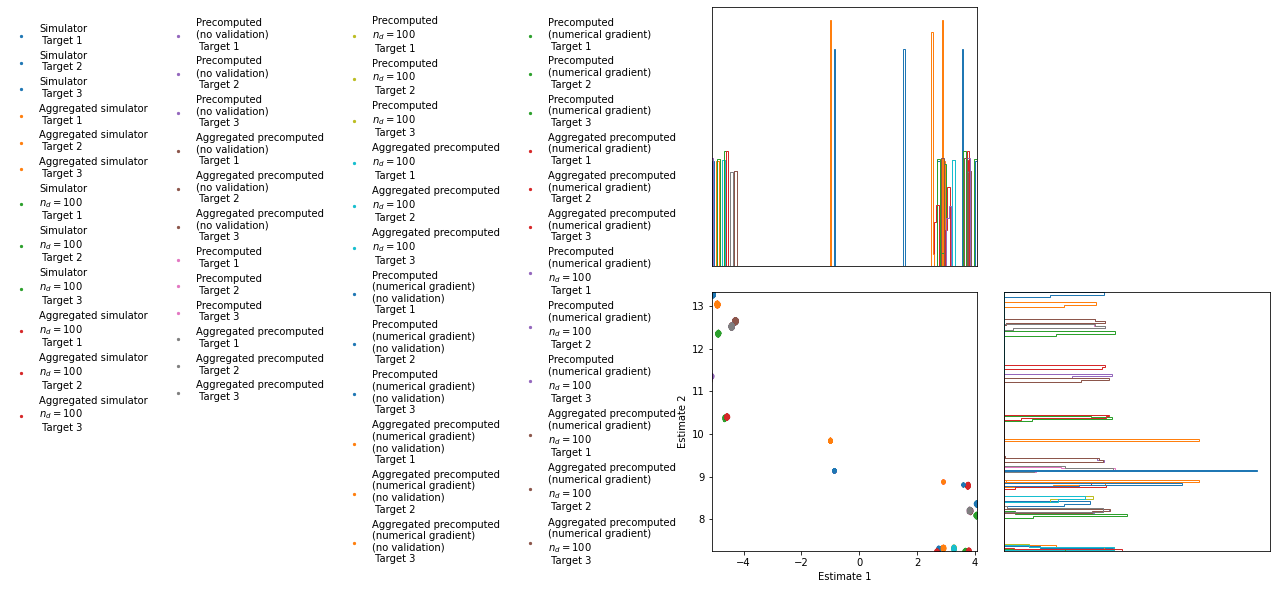

In [50]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax = ABC.scatter_summaries(
            axis_labels=["Estimate 1", "Estimate 2"],
            label=label,
            colours="C{}".format(i),
        )
    else:
        ABC.scatter_summaries(ax=ax, label=label, colours="C{}".format(i), ncol=4, bbox_to_anchor=(-0.1, 1.0))

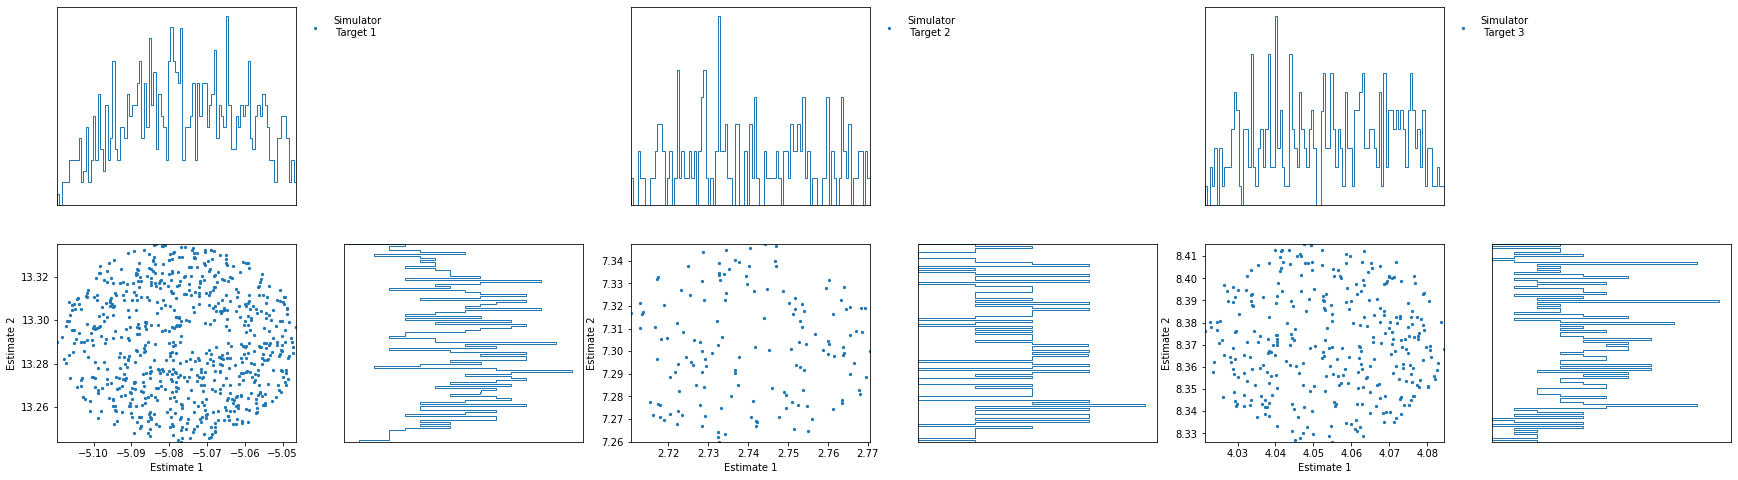

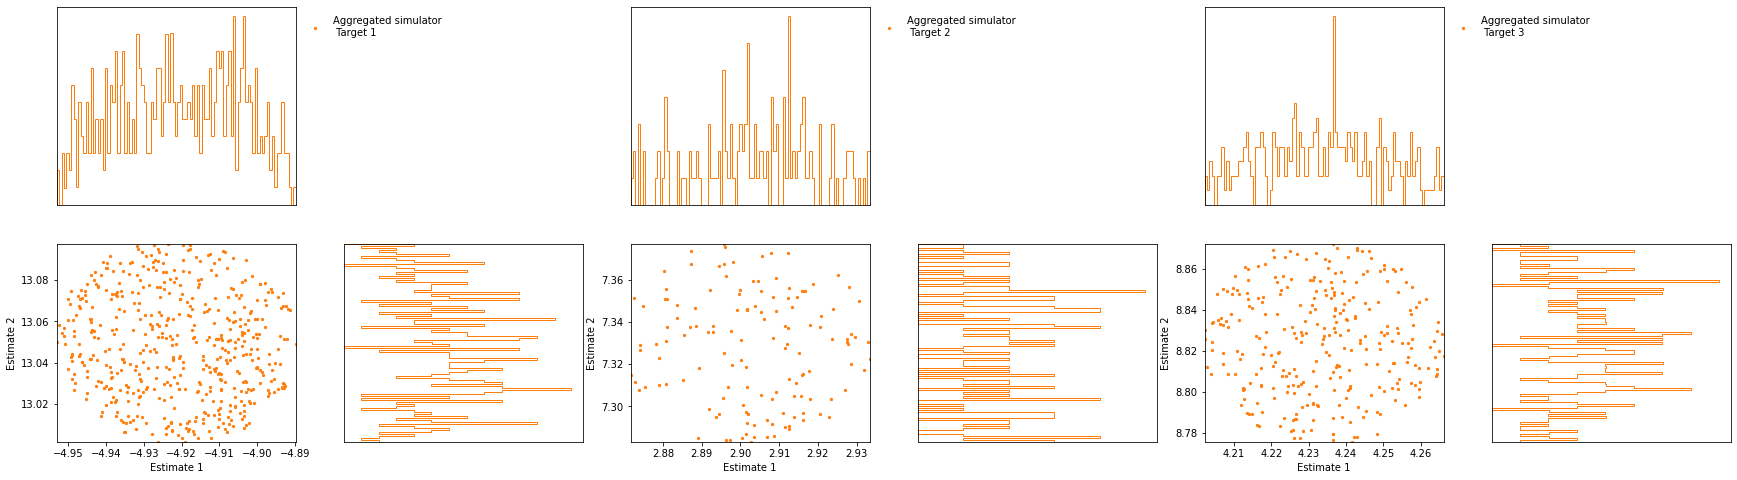

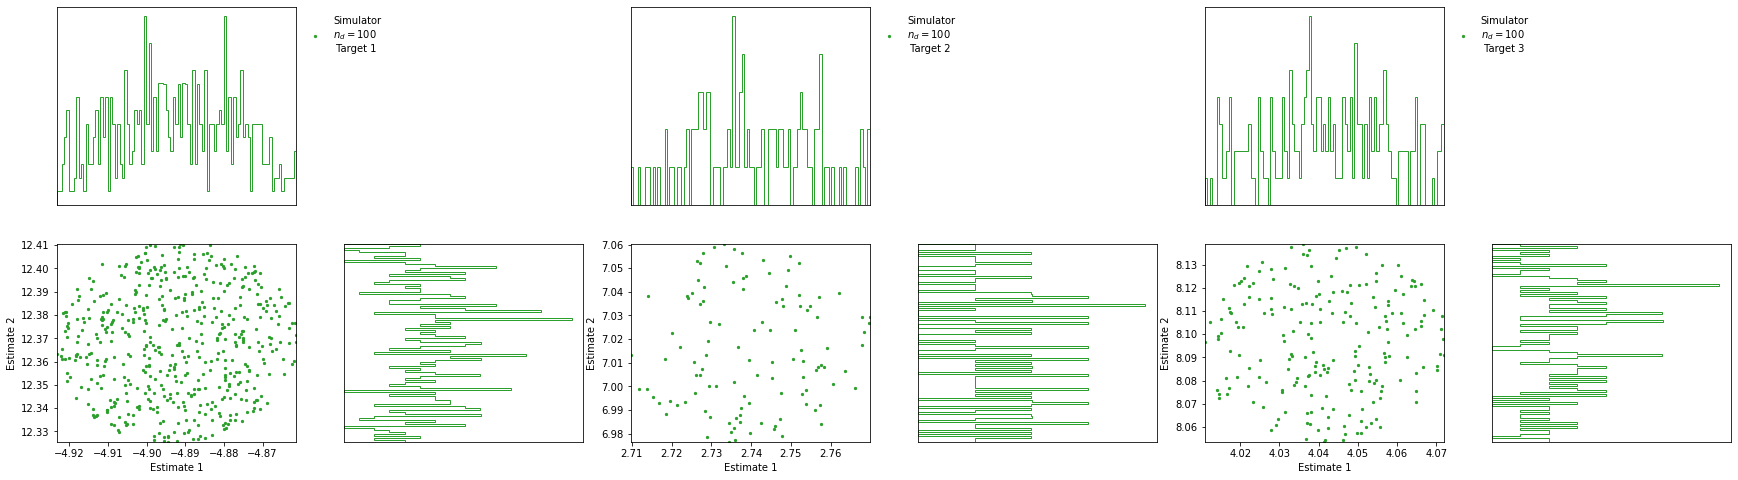

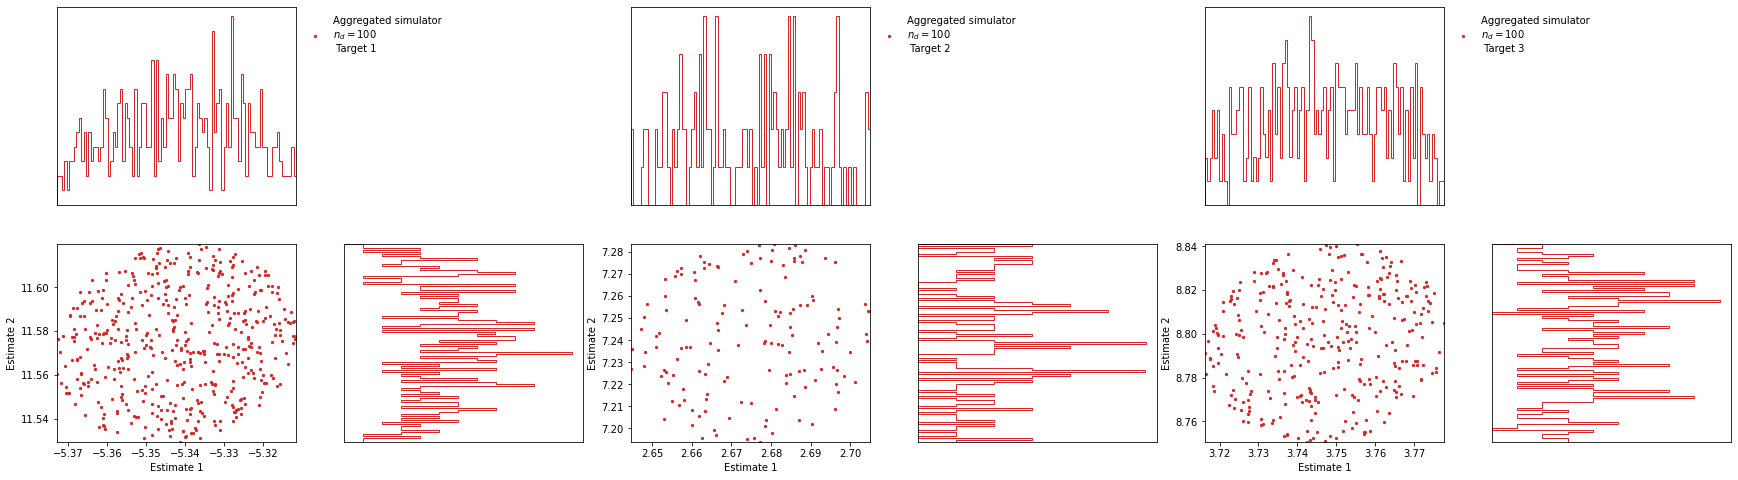

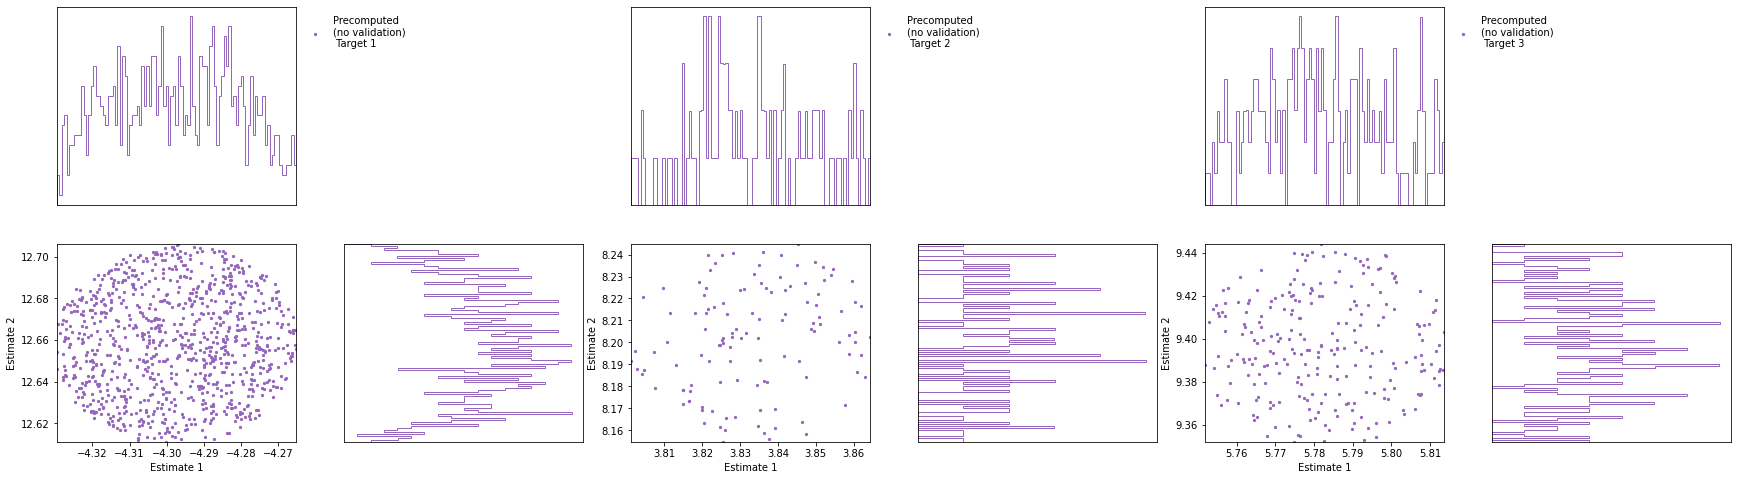

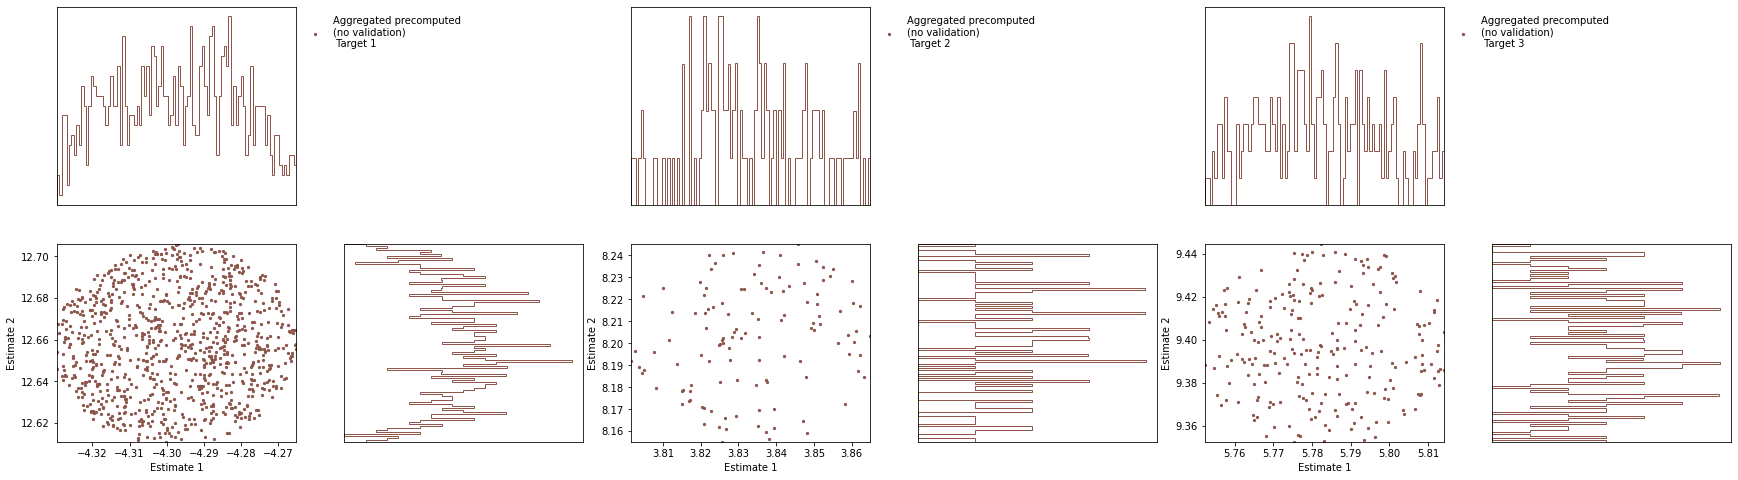

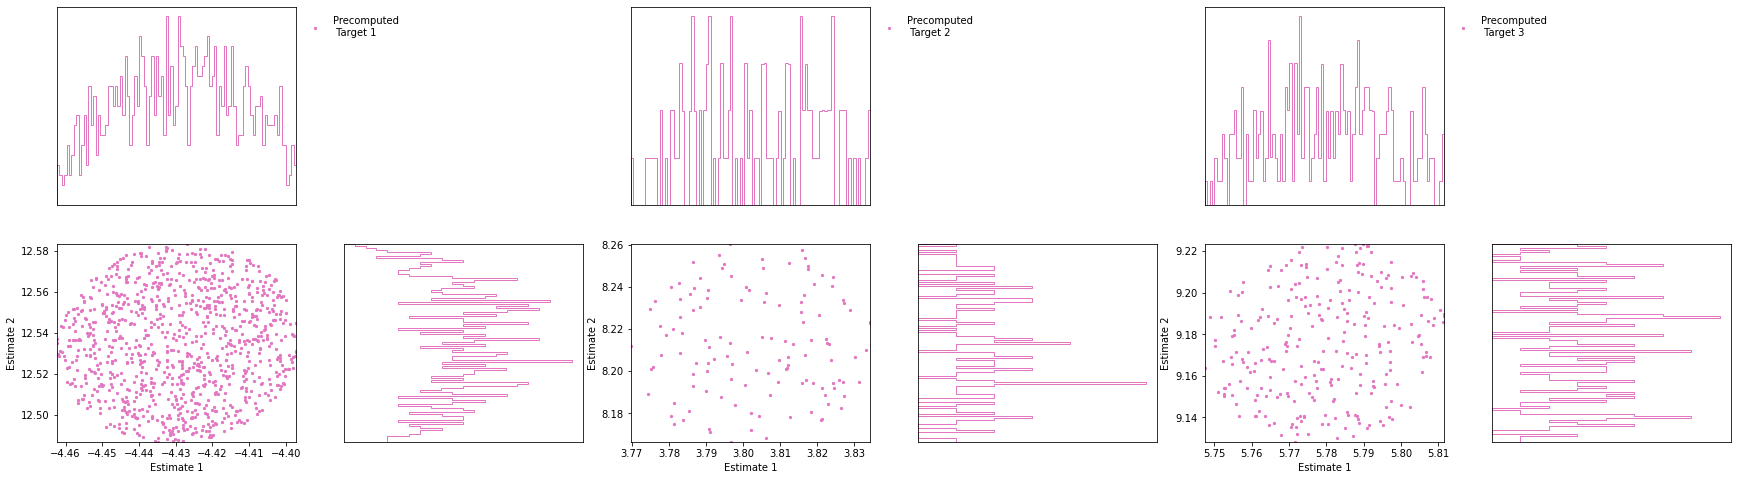

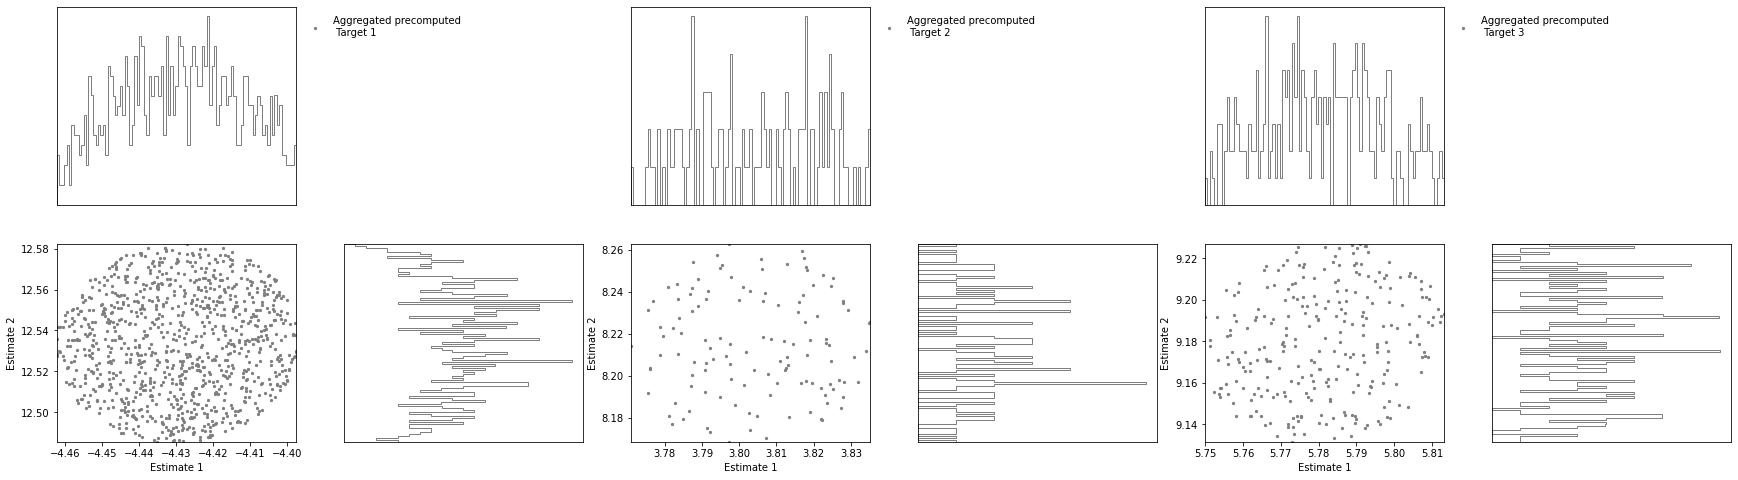

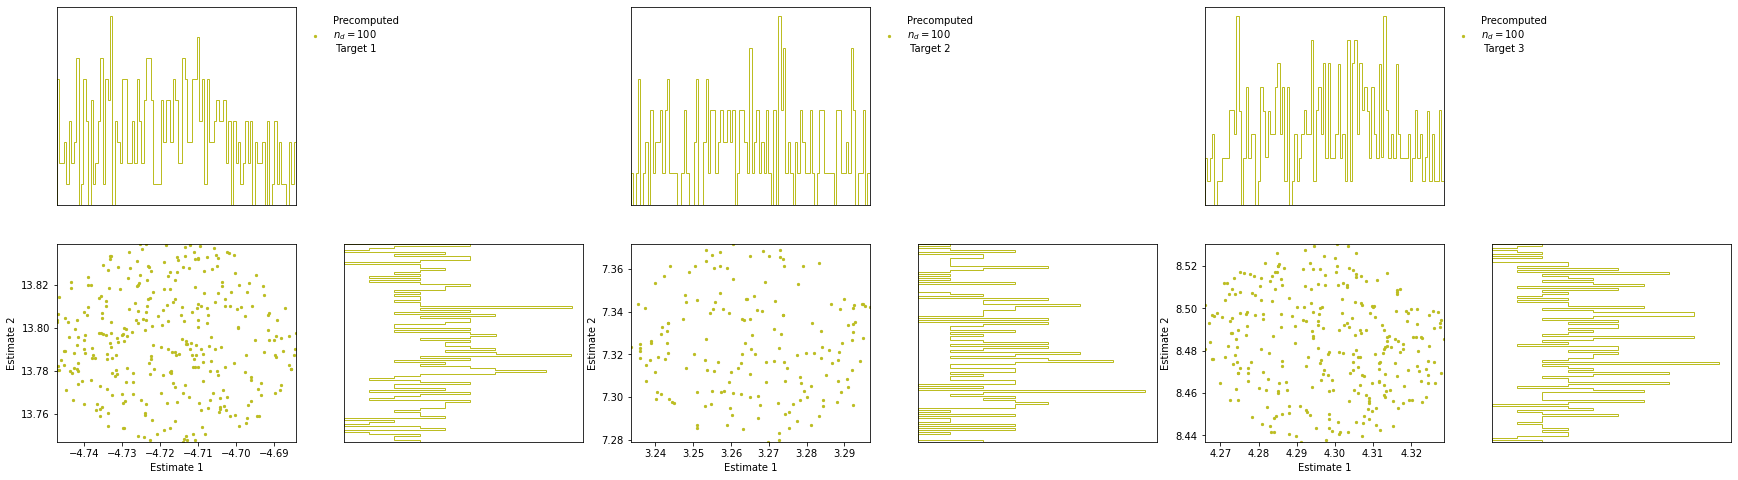

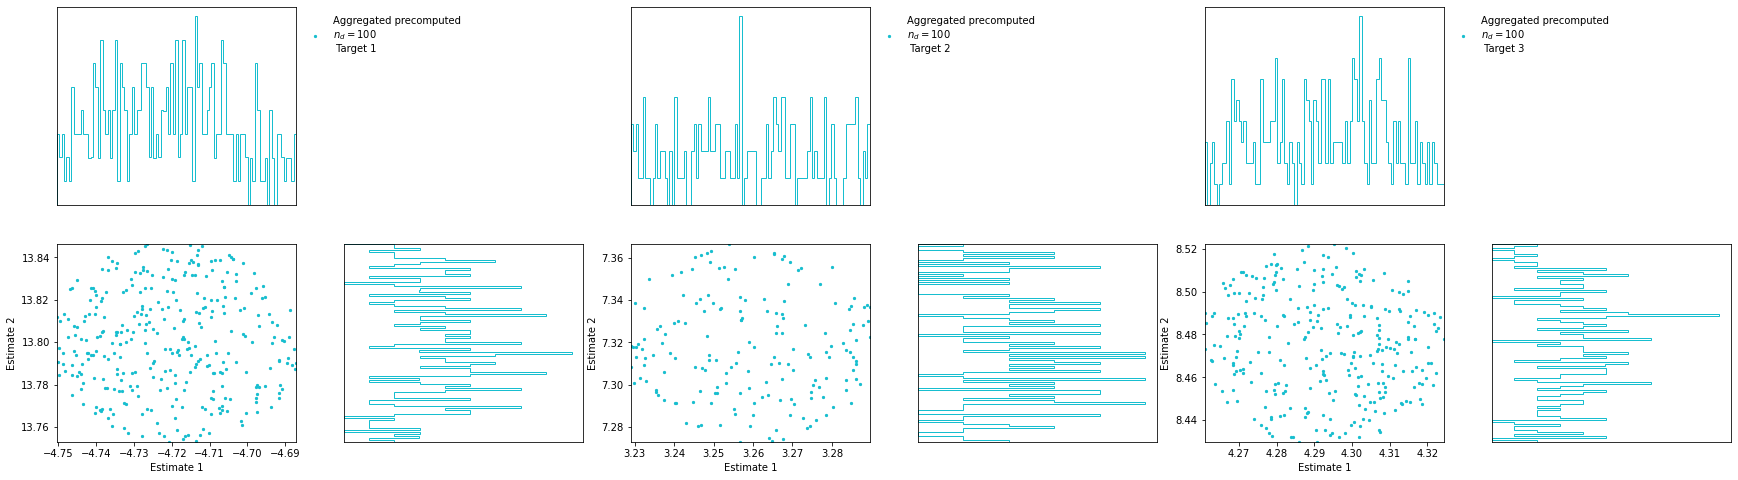

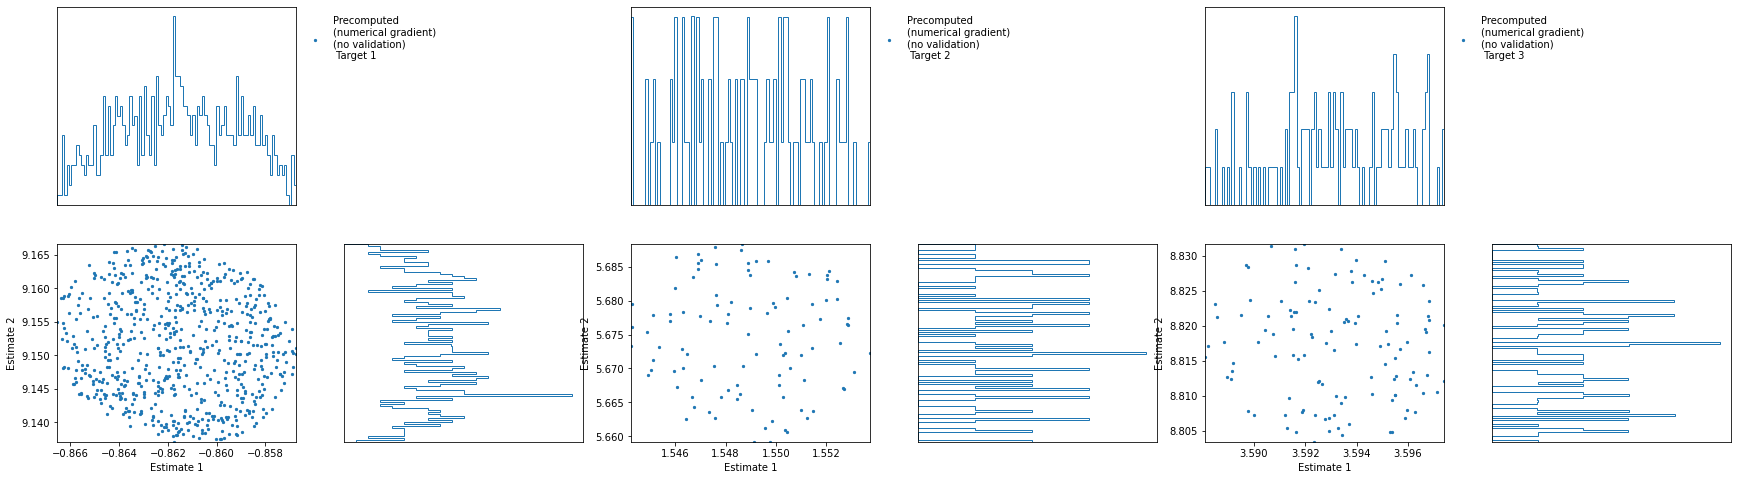

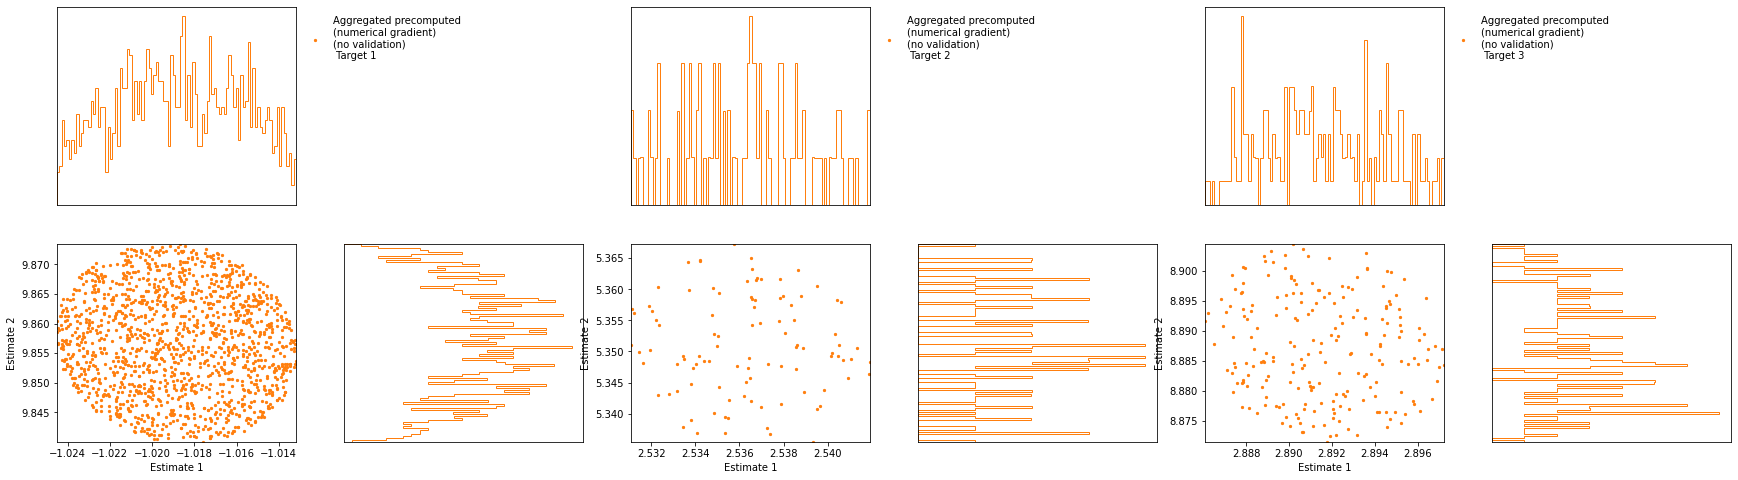

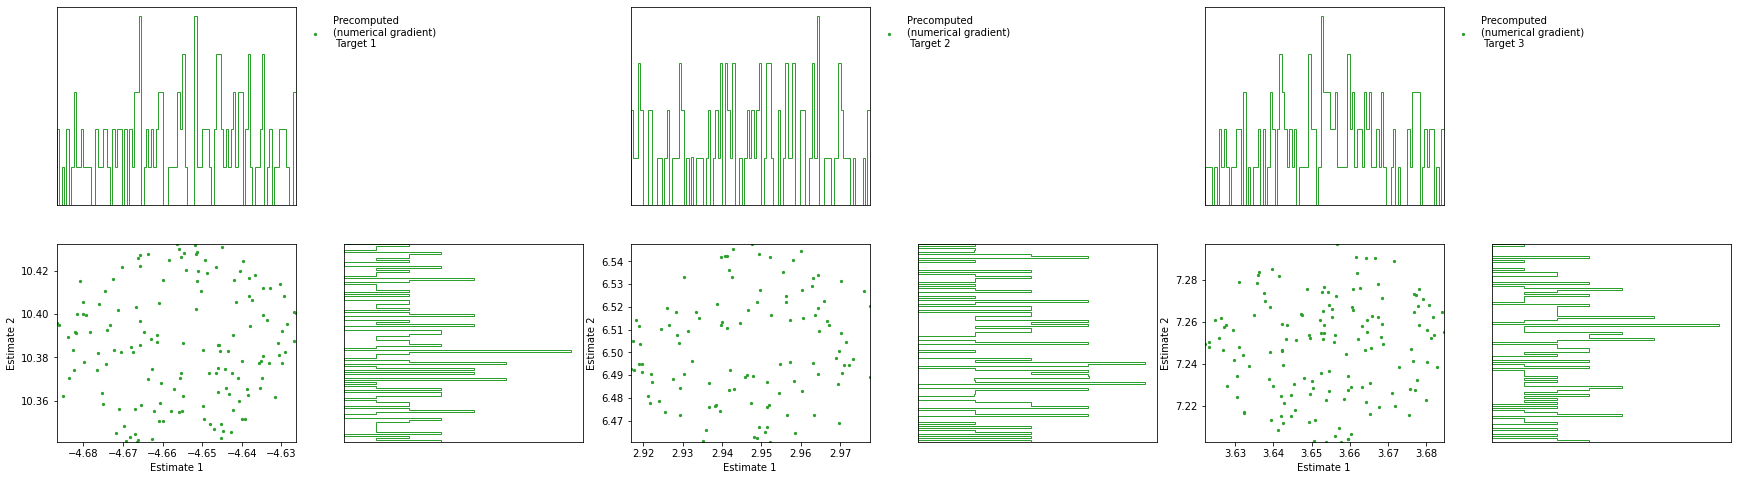

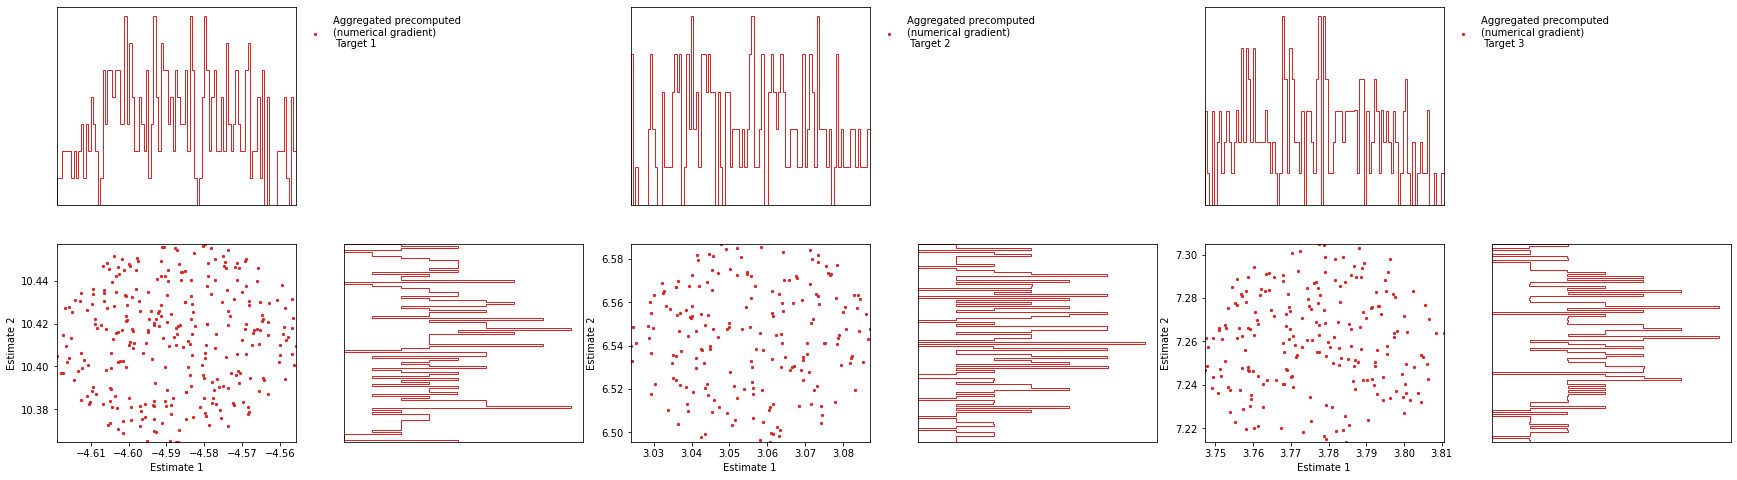

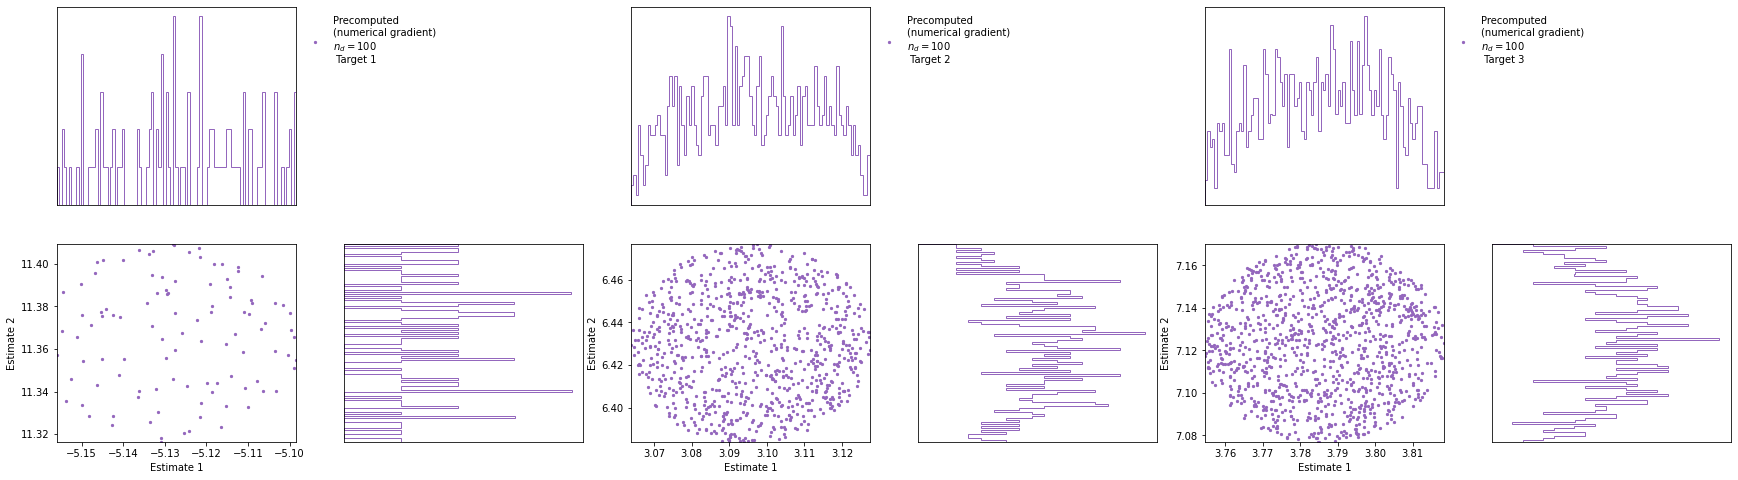

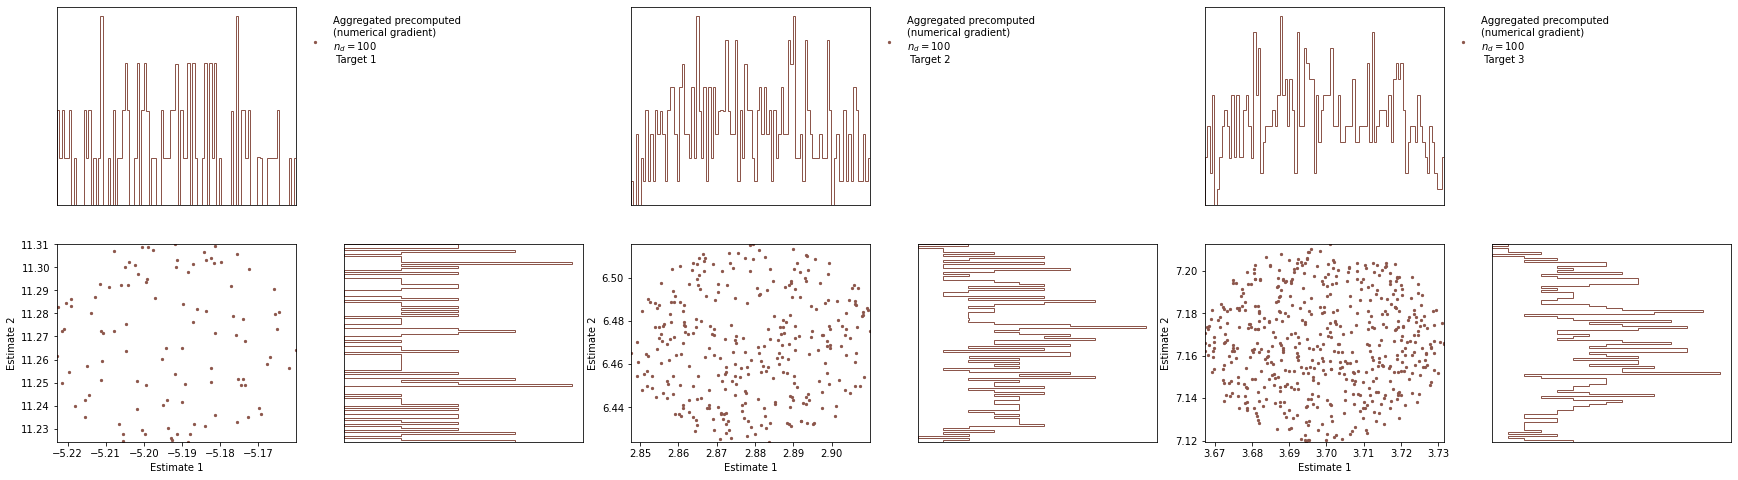

In [48]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    fig, ax = plt.subplots(2, 6, figsize=(30, 8))
    ABC.scatter_summaries(
        ax=ax[:, :2],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=0,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )
    ABC.scatter_summaries(
        ax=ax[:, 2:4],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=1,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )
    ABC.scatter_summaries(
        ax=ax[:, 4:],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=2,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )